# CMU 10-605 auto-graded notebook

Before you turn this assignment in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE."

---

# Homework 3: Logistic Regression

In [0]:
# Who did you collaborate with on this assignment? 
# if no one, collaborators should contain an empty string,
# else list your collaborators below

collaborators = [""]
# YOUR CODE HERE
#raise NotImplementedError()

In [0]:
try:
    collaborators
except:
    raise AssertionError("you did not list your collaborators, if any")

# Click-Through Rate Prediction
In this section you will go through the steps for creating a click-through rate (CTR) prediction pipeline. You will work with the Criteo Labs dataset.

## This section will cover:

* *Part 1:* Featurize categorical data using one-hot-encoding (OHE)

* *Part 2:* Construct an OHE dictionary

* *Part 3:* Parse CTR data and generate OHE features
 * *Visualization 1:* Feature frequency

* *Part 4:* CTR prediction and logloss evaluation
 * *Visualization 2:* ROC curve

* *Part 5:* Reduce feature dimension via feature hashing

> Note that, for reference, you can look up the details of:
> * the relevant Spark methods in [PySpark's DataFrame API](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.html)
> * the relevant NumPy methods in the [NumPy Reference](http://docs.scipy.org/doc/numpy/reference/index.html)

> Here is a list of functions that you may find useful:
> * [alias](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.alias.html)
> * [cast](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.Column.cast.html)
> * [collectAsMap](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.collectAsMap.html)
> * [distinct](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.distinct.html)
> * [explode](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.explode.html)
> * [getItem](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.Column.getItem.html)
> * [lit](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.functions.lit.html)
> * [selectExpr](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.selectExpr.html)
> * [split](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.split.html)
> * [when](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.when.html)
> * [zipWithIndex](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.zipWithIndex.html)

In [0]:
from nose.tools import assert_equal, assert_true

In [0]:
# YOU CAN MOST LIKELY IGNORE THIS CELL. This is only of use for running this notebook locally.

# THIS CELL DOES NOT NEED TO BE RUN ON DATABRICKS. 
# Note that Databricks already creates a SparkContext for you, so this cell can be skipped.
import findspark
findspark.init()
import pyspark
from pyspark.sql import SQLContext
sc = pyspark.SparkContext(appName="hw")
sqlContext = SQLContext(sc)

print("spark context started")

## Part 1: Featurize categorical data using one-hot-encoding

### (1a) One-hot-encoding

We would like to develop code to convert categorical features to numerical ones. In order to build intuition, we will work with a unlabeled dataset with three data points, with each data point representing an animal. The first feature indicates the type of animal (bear, cat, mouse); the second feature describes the animal's color (black, tabby); and the third (optional) feature describes what the animal eats (mouse, salmon).

In a one-hot-encoding (OHE) scheme, we want to represent each tuple of `(featureID, category)` via its own binary feature.  We can do this in Python by creating a dictionary that maps each tuple to a distinct integer, where the integer corresponds to a binary feature. To start, manually enter the entries in the OHE dictionary associated with the sample dataset by mapping the tuples to consecutive integers starting from zero,  ordering the tuples first by featureID and next by category.

Later in this lab, we'll use OHE dictionaries to transform data points into compact lists of features that can be used in machine learning algorithms.

In [0]:
# By default, when a shuffle operation occurs with DataFrames, the post-shuffle partition
# count is 200. This is controlled by Spark configuration value spark.sql.shuffle.partitions.
# 200 is a little too high for this data set, so we set the post-shuffle partition count to
# twice the number of available threads in Community Edition.
sqlContext.setConf('spark.sql.shuffle.partitions', '6')  # Set default partitions for DataFrame operations

In [0]:
from collections import defaultdict
# Data for manual OHE
# Note: the first data point does not include any value for the optional third feature
sample_one = [(0, 'mouse'), (1, 'black')]
sample_two = [(0, 'cat'), (1, 'tabby'), (2, 'mouse')]
sample_three =  [(0, 'bear'), (1, 'black'), (2, 'salmon')]

def sample_to_row(sample):
    tmp_dict = defaultdict(lambda: None)
    tmp_dict.update(sample)
    return [tmp_dict[i] for i in range(3)]

sqlContext.createDataFrame(map(sample_to_row, [sample_one, sample_two, sample_three]),
                           ['animal', 'color', 'food']).show()
sample_data_df = sqlContext.createDataFrame([(sample_one,), (sample_two,), (sample_three,)], ['features'])
sample_data_df.show(truncate=False)

+------+-----+------+
|animal|color|  food|
+------+-----+------+
| mouse|black|  null|
|   cat|tabby| mouse|
|  bear|black|salmon|
+------+-----+------+

+------------------------------------+
|features                            |
+------------------------------------+
|[{0, mouse}, {1, black}]            |
|[{0, cat}, {1, tabby}, {2, mouse}]  |
|[{0, bear}, {1, black}, {2, salmon}]|
+------------------------------------+



In [0]:
# # TODO: Replace <FILL IN> with appropriate code
# sample_ohe_dict_manual = {}
# sample_ohe_dict_manual[(0, 'bear')] = <FILL IN >
# sample_ohe_dict_manual[(0, 'cat')] = <FILL IN >
# sample_ohe_dict_manual[(0, 'mouse')] = <FILL IN >
# sample_ohe_dict_manual < FILL IN >
# sample_ohe_dict_manual < FILL IN >
# sample_ohe_dict_manual < FILL IN >
# sample_ohe_dict_manual < FILL IN >

# YOUR CODE HERE
sample_ohe_dict_manual = {}
sample_ohe_dict_manual[(0, 'bear')] = 0
sample_ohe_dict_manual[(0, 'cat')] = 1
sample_ohe_dict_manual[(0, 'mouse')] = 2
sample_ohe_dict_manual[(1, 'black')] = 3
sample_ohe_dict_manual[(1, 'tabby')] = 4
sample_ohe_dict_manual[(2, 'mouse')] = 5
sample_ohe_dict_manual[(2, 'salmon')] = 6

In [0]:
# TEST One-hot-encoding (1a)
assert_equal(sample_ohe_dict_manual[(0, 'bear')], 0)
assert_equal(sample_ohe_dict_manual[(0, 'cat')], 1)
assert_equal(sample_ohe_dict_manual[(0, 'mouse')], 2)
assert_equal(len(sample_ohe_dict_manual.keys()), 7)

### (1b) Sparse vectors

Data points can typically be represented with a small number of non-zero OHE features which are relative to the total number of features that occur in the dataset.  By leveraging this sparsity and using sparse vector representations for OHE data, we can reduce storage and computational burdens.  Below are a few sample vectors represented as dense numpy arrays.  Use [SparseVector](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.linalg.SparseVector.html) to represent them in a sparse fashion, and verify that both the sparse and dense representations yield the same results when computing [dot products](http://en.wikipedia.org/wiki/Dot_product) (we will later use MLlib to train classifiers via gradient descent, and MLlib will need to compute dot products between SparseVectors and dense parameter vectors).

Use `SparseVector(size, *args)` to create a new sparse vector where size is the length of the vector and args are either:
1. A list of indices and a list of values corresponding to the indices. See the link above for details. HINT: The indices list must be sorted in ascending order. If you didn't sort the indices list, for example, SparseVector(3, [2, 1], [5, 5]) will give you an error. Note: you cannot simply sort the indices list, think about why.
2. A list of (index, value) pair. In this case, the indices need not be sorted. See the link above for details.

SparseVectors are much more efficient when working with sparse data because they do not store zero values (only store non-zero values and their indices). You'll need to create a sparse vector representation of each dense vector `a_dense` and `b_dense`.

In [0]:
import numpy as np
from pyspark.ml.linalg import SparseVector

In [0]:
# # TODO: Uncomment the lines below and replace <FILL IN> with appropriate code
# a_dense = np.array([0., 3., 0., 4.])
# a_sparse = <FILL IN >

# b_dense = np.array([0., 0., 0., 1.])
# b_sparse = <FILL IN >

# YOUR CODE HERE
a_dense = np.array([0., 3., 0., 4.])
a_nonzero_i = np.flatnonzero(a_dense)
a_nonzero_v = a_dense.ravel()[a_nonzero_i]
# print(a_nonzero_i,a_nonzero_v)
a_sparse = SparseVector(len(a_dense), a_nonzero_i,a_nonzero_v)

b_dense = np.array([0., 0., 0., 1.])
b_nonzero_i = np.flatnonzero(b_dense)
b_nonzero_v = b_dense.ravel()[b_nonzero_i]
b_sparse = SparseVector(len(b_dense), b_nonzero_i,b_nonzero_v)

w = np.array([0.4, 3.1, -1.4, -.5])
print(a_dense.dot(w))
print(a_sparse.dot(w))
print(b_dense.dot(w))
print(b_sparse.dot(w))

7.300000000000001
7.300000000000001
-0.5
-0.5


In [0]:
# TEST Sparse Vectors (1b)
assert_true(isinstance(a_sparse, SparseVector), 'a_sparse needs to be an instance of SparseVector')
assert_true(b_dense.dot(w) == b_sparse.dot(w),
                'dot product of b_dense and w should equal dot product of b_sparse and w')
assert_true(a_sparse.numNonzeros() == 2, 'a_sparse should not store zero values')

### (1c) OHE features as sparse vectors

Now let's see how we can represent the OHE features for points in our sample dataset.  Using the mapping defined by the OHE dictionary from Part (1a), manually define OHE features for the three sample data points using SparseVector format.  In this case, all the features will have a value of 1.0.  For example, the `DenseVector` for a point with features 2 and 4 would be `[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]`.

In [0]:
# Reminder of the sample features
# sample_one = [(0, 'mouse'), (1, 'black')]
# sample_two = [(0, 'cat'), (1, 'tabby'), (2, 'mouse')]
# sample_three =  [(0, 'bear'), (1, 'black'), (2, 'salmon')]

In [0]:
# # TODO: Uncomment the lines below and replace <FILL IN> with appropriate code. Use SparseVector()
# sample_one_ohe_feat_manual = <FILL IN >
# sample_two_ohe_feat_manual = <FILL IN >
# sample_three_ohe_feat_manual = <FILL IN >

# YOUR CODE HERE
def gen_dense_feature_index(sample,sample_ohe_dict_manual):
    index_list = []
    for f in sample:
        index_list.append(sample_ohe_dict_manual[f])
    index_list = sorted(index_list)
    return index_list

def gen_dense_feature_value(sample,sample_ohe_dict_manual):
    index_list = []
    for f in sample:
        index_list.append(sample_ohe_dict_manual[f])
    index_list = sorted(index_list)
    return [1 for x in range(len(index_list))]
    
sample_one_ohe_feat_manual = SparseVector(len(sample_ohe_dict_manual), gen_dense_feature_index(sample_one,sample_ohe_dict_manual),gen_dense_feature_value(sample_one,sample_ohe_dict_manual))
sample_two_ohe_feat_manual = SparseVector(len(sample_ohe_dict_manual), gen_dense_feature_index(sample_two,sample_ohe_dict_manual),gen_dense_feature_value(sample_two,sample_ohe_dict_manual))
sample_three_ohe_feat_manual = SparseVector(len(sample_ohe_dict_manual), gen_dense_feature_index(sample_three,sample_ohe_dict_manual),gen_dense_feature_value(sample_three,sample_ohe_dict_manual))

In [0]:
# TEST OHE Features as sparse vectors (1c)
assert_true(isinstance(sample_one_ohe_feat_manual, SparseVector),
                'sample_one_ohe_feat_manual needs to be a SparseVector')
assert_true(isinstance(sample_two_ohe_feat_manual, SparseVector),
                'sample_two_ohe_feat_manual needs to be a SparseVector')
assert_true(isinstance(sample_three_ohe_feat_manual, SparseVector),
                'sample_three_ohe_feat_manual needs to be a SparseVector')

assert_equal(sample_one_ohe_feat_manual[2], 1.0, 'incorrect value for sample_one_ohe_feat_manual')
assert_equal(sample_one_ohe_feat_manual[3], 1.0, 'incorrect value for sample_one_ohe_feat_manual')


### (1d) Define a OHE function

Next we will use the OHE dictionary from Part (1a) to programatically generate OHE features from the original categorical data.  First write a function called `one_hot_encoding` that creates OHE feature vectors in `SparseVector` format.  Then use this function to create OHE features for the first sample data point and verify that the result matches the result from Part (1c).

> Note: We'll pass in the OHE dictionary as a [Broadcast](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.Broadcast.html) variable, which will greatly improve performance when we call this function as part of a UDF. **HINT: study the documentation of Broadcast variable, make sure you understand how to access broadcast variable.**  For instance: `ohe_dict_broadcast.<WHAT>`.

In [0]:
# TODO: Uncomment the lines below and replace <FILL IN> with appropriate code
def one_hot_encoding(raw_feats, ohe_dict_broadcast, num_ohe_feats):
    """Produce a one-hot-encoding from a list of features and an OHE dictionary.
    
    Note:
        You should ensure that the indices used to create a SparseVector are sorted.

    Args:
        raw_feats (list of (int, str)): The features corresponding to a single observation.  Each
            feature consists of a tuple of featureID and the feature's value. (e.g. sample_one)
        ohe_dict_broadcast (Broadcast of dict): Broadcast variable containing a dict that maps
            (featureID, value) to unique integer.
        num_ohe_feats (int): The total number of unique OHE features (combinations of featureID and
            value).

    Returns:
        SparseVector: A SparseVector of length num_ohe_feats with indices equal to the unique
            identifiers for the (featureID, value) combinations that occur in the observation and
            with values equal to 1.0.
    """
    index_list = []
    for f in raw_feats:
        index_list.append(ohe_dict_broadcast.value[f])
    index_list = sorted(index_list)
    value_list = [1] * len(index_list)
    return SparseVector(num_ohe_feats, index_list,value_list)
    raise NotImplementedError()
    
# Calculate the number of features in sample_ohe_dict_manual
# num_sample_ohe_feats = <FILL IN >
# sample_ohe_dict_manual_broadcast = sc.broadcast(sample_ohe_dict_manual)

# # Run one_hot_encoding() on sample_one.  Make sure to pass in the Broadcast variable.
# sample_one_ohe_feat = <FILL IN >  
  
# YOUR CODE HERE
num_sample_ohe_feats = len(sample_ohe_dict_manual)
sample_ohe_dict_manual_broadcast = sc.broadcast(sample_ohe_dict_manual)

# Run one_hot_encoding() on sample_one.  Make sure to pass in the Broadcast variable.
sample_one_ohe_feat = one_hot_encoding(sample_one, sample_ohe_dict_manual_broadcast, num_sample_ohe_feats)

print(sample_one_ohe_feat)

(7,[2,3],[1.0,1.0])


In [0]:
# TEST Define an OHE Function (1d)
assert_true(sample_one_ohe_feat == sample_one_ohe_feat_manual,
                'sample_one_ohe_feat should equal sample_one_ohe_feat_manual')
assert_equal(sample_one_ohe_feat, SparseVector(7, [2, 3], [1.0, 1.0]),
                  'incorrect value for sample_one_ohe_feat')
assert_equal(one_hot_encoding([(1, 'black'), (0, 'mouse')], sample_ohe_dict_manual_broadcast,
                                   num_sample_ohe_feats), SparseVector(7, [2, 3], [1.0, 1.0]),
                  'incorrect definition for one_hot_encoding')

### (1e) Apply OHE to a dataset

Finally, use the function from Part (1d) to create OHE features for all 3 data points in the sample dataset.  You'll need to generate a [UDF](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.udf.html) that can be used in a `DataFrame` `select` statement.

> Note: Your implemenation of `ohe_udf_generator` needs to call your `one_hot_encoding` function.

In [0]:
# TODO: Uncomment the lines below and replace <FILL IN> with appropriate code
from pyspark.sql.functions import udf
from pyspark.ml.linalg import VectorUDT

def ohe_udf_generator(ohe_dict_broadcast):
    """Generate a UDF that is setup to one-hot-encode rows with the given dictionary.

    Note:
        We'll reuse this function to generate a UDF that can one-hot-encode rows based on a
        one-hot-encoding dictionary built from the training data.  Also, you should calculate
        the number of features before calling the one_hot_encoding function.
        
    HINT:
        Return type of the udf will be VectorUDT.

    Args:
        ohe_dict_broadcast (Broadcast of dict): Broadcast variable containing a dict that maps
            (featureID, value) to unique integer.

    Returns:
        UserDefinedFunction: A UDF can be used in `DataFrame` `select` statement to call a
            function on each row in a given column.  This UDF should call the one_hot_encoding
            function with the appropriate parameters.
    """
    # YOUR CODE HERE
    return udf(lambda x: one_hot_encoding(x, ohe_dict_broadcast, len(ohe_dict_broadcast.value)),VectorUDT())
    raise NotImplementedError()

# sample_ohe_dict_udf = ohe_udf_generator(sample_ohe_dict_manual_broadcast)
# sample_ohe_df = sample_data_df.select( < FILL IN >)
# sample_ohe_df.show(truncate=False)

# YOUR CODE HERE
sample_ohe_dict_udf = ohe_udf_generator(sample_ohe_dict_manual_broadcast)
sample_ohe_df = sample_data_df.select(sample_ohe_dict_udf("features"))
sample_ohe_df.show(truncate=False)

+-------------------------+
|<lambda>(features)       |
+-------------------------+
|(7,[2,3],[1.0,1.0])      |
|(7,[1,4,5],[1.0,1.0,1.0])|
|(7,[0,3,6],[1.0,1.0,1.0])|
+-------------------------+



In [0]:
# TEST Apply OHE to a dataset (1e)
sample_ohe_data_values = sample_ohe_df.collect()
assert_true(len(sample_ohe_data_values) == 3, 'sample_ohe_data_values should have three elements')
assert_equal(sample_ohe_data_values[0], (SparseVector(7, {2: 1.0, 3: 1.0}),),
                  'incorrect OHE for first sample')
assert_equal(sample_ohe_data_values[1], (SparseVector(7, {1: 1.0, 4: 1.0, 5: 1.0}),),
                  'incorrect OHE for second sample')
assert_equal(sample_ohe_data_values[2], (SparseVector(7, {0: 1.0, 3: 1.0, 6: 1.0}),),
                  'incorrect OHE for third sample')

---------------------------------------------------------------------------
AssertionError                            Traceback (most recent call last)
<command-3300230847040902> in <cell line: 4>()
      2 sample_ohe_data_values = sample_ohe_df.collect()
      3 assert_true(len(sample_ohe_data_values) == 3, 'sample_ohe_data_values should have three elements')
----> 4 assert_equal(sample_ohe_data_values[0], (SparseVector(7, {2: 1.0, 3: 1.0}),),
      5                   'incorrect OHE for first sample')
      6 assert_equal(sample_ohe_data_values[1], (SparseVector(7, {1: 1.0, 4: 1.0, 5: 1.0}),),

/usr/lib/python3.9/unittest/case.py in assertEqual(self, first, second, msg)
    829         """
    830         assertion_func = self._getAssertEqualityFunc(first, second)
--> 831         assertion_func(first, second, msg=msg)
    832 
    833     def assertNotEqual(self, first, second, msg=None):

/usr/lib/python3.9/unittest/case.py in _baseAssertEqual(self, first, second, msg)
    822      

## Part 2: Construct an OHE dictionary

### (2a) DataFrame with rows of `(featureID, category)`

To start, create a DataFrame of distinct `(feature_id, category)` tuples. In our sample dataset, the 7 items in the resulting DataFrame are `(0, 'bear')`, `(0, 'cat')`, `(0, 'mouse')`, `(1, 'black')`, `(1, 'tabby')`, `(2, 'mouse')`, `(2, 'salmon')`. Notably `'black'` appears twice in the dataset but only contributes one item to the DataFrame: `(1, 'black')`, while `'mouse'` also appears twice and contributes two items: `(0, 'mouse')` and `(2, 'mouse')`.

In [0]:
sample_data_df

Out[19]: DataFrame[features: array<struct<_1:bigint,_2:string>>]

In [0]:
# TODO: Uncomment the lines below and replace <FILL IN> with appropriate code
from pyspark.sql.functions import explode
# sample_distinct_feats_df = (sample_data_df
#                               <FILL IN>)
# YOUR CODE HERE

sample_distinct_feats_df = (sample_data_df.select(explode("features")).dropDuplicates())
sample_distinct_feats_df.show()

+-----------+
|        col|
+-----------+
| {0, mouse}|
| {1, black}|
|   {0, cat}|
| {2, mouse}|
| {1, tabby}|
|{2, salmon}|
|  {0, bear}|
+-----------+



In [0]:
# TEST DataFrame with rows of `(featureID, category)` (2a)
assert_equal(sorted(map(lambda r: r[0], sample_distinct_feats_df.collect())),
                  [(0, 'bear'), (0, 'cat'), (0, 'mouse'), (1, 'black'),
                   (1, 'tabby'), (2, 'mouse'), (2, 'salmon')],
                  'incorrect value for sample_distinct_feats_df')

### (2b) OHE Dictionary from distinct features

Next, create an RDD of key-value tuples, where 
key is `(feature_id, category)` tuple in `sample_distinct_feats_df` 
and the values are distinct integers ranging from 0 to (number of keys - 1).  
Then convert this RDD into a dictionary. 

Note that there is no unique mapping from keys to values, as all we require is that each `(featureID, category)` key be mapped to a unique integer between 0 and the number of keys.  In this exercise, any valid mapping is acceptable.  

HINT: [zipWithIndex](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.zipWithIndex.html) and [collectAsMap](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.collectAsMap.html) may be useful here.

In our sample dataset, one valid list of key-value tuples is: `[((0, 'bear'), 0), ((2, 'salmon'), 1), ((1, 'tabby'), 2), ((2, 'mouse'), 3), ((0, 'mouse'), 4), ((0, 'cat'), 5), ((1, 'black'), 6)]`. The dictionary defined in Part (1a) illustrates another valid mapping between keys and integers.

> Note: We provide the code to convert the DataFrame to an RDD.

In [0]:
# # TODO: Uncomment the lines below and replace <FILL IN> with appropriate code
# sample_ohe_dict = (sample_distinct_feats_df
#                      .rdd
#                      .map(lambda r: tuple(r[0]))
#                      <FILL IN>)

# YOUR CODE HERE
sample_ohe_dict = (sample_distinct_feats_df
                     .rdd
                     .map(lambda r: tuple(r[0]))
                     .zipWithIndex().collectAsMap())
print(sample_ohe_dict)

{(0, 'mouse'): 0, (1, 'black'): 1, (0, 'cat'): 2, (2, 'mouse'): 3, (1, 'tabby'): 4, (2, 'salmon'): 5, (0, 'bear'): 6}


In [0]:
# TEST OHE Dictionary from distinct features (2b)
assert_equal(sorted(sample_ohe_dict.keys()),
                  [(0, 'bear'), (0, 'cat'), (0, 'mouse'), (1, 'black'),
                   (1, 'tabby'), (2, 'mouse'), (2, 'salmon')],
                  'sample_ohe_dict has unexpected keys')
assert_equal(sorted(sample_ohe_dict.values()), list(range(7)), 'sample_ohe_dict has unexpected values')

### (2c) Automated creation of an OHE dictionary

Now use the code from Parts (2a) and (2b) to write a function that takes an input dataset and outputs an OHE dictionary. Then use this function to create an OHE dictionary for the sample dataset, and verify it matches the dictionary from Part (2b).

In [0]:
# TODO: Uncomment the lines below and replace <FILL IN> with appropriate code
def create_one_hot_dict(input_df):
    """Creates a one-hot-encoder dictionary based on the input data.
    
    TODO:
        1) Find distinct (feature_id, category) tuples in the input DataFrame.
        2) Create a dictionary mapping (feature_id, category) tuples to unique integers.        

    Args:
        input_df (DataFrame with 'features' column): A DataFrame where each row contains a list of
            (featureID, value) tuples.

    Returns:
        dict: A dictionary where the keys are (featureID, value) tuples and map to values that are
            unique integers.
    """    
    # YOUR CODE HERE
    sample_distinct_feats_df = (input_df.select(explode("features")).dropDuplicates())
    sample_ohe_dict = (sample_distinct_feats_df
                     .rdd
                     .map(lambda r: tuple(r[0]))
                     .zipWithIndex().collectAsMap())
    return sample_ohe_dict
    raise NotImplementedError()

sample_ohe_dict_auto = create_one_hot_dict(sample_data_df)

In [0]:
# TEST Automated creation of an OHE dictionary (2c)
assert_equal(sorted(sample_ohe_dict_auto.keys()),
                  [(0, 'bear'), (0, 'cat'), (0, 'mouse'), (1, 'black'),
                   (1, 'tabby'), (2, 'mouse'), (2, 'salmon')],
                  'sample_ohe_dict_auto has unexpected keys')
assert_equal(sorted(sample_ohe_dict_auto.values()), list(range(7)),
                  'sample_ohe_dict_auto has unexpected values')

## Part 3: Parse CTR data and generate OHE features

***Before we can proceed, you'll first need to obtain the sample data.  ***

The data is from a past [kaggle competition](https://www.kaggle.com/c/criteo-display-ad-challenge/overview). The original data was too big. So we randomly samepled the data for this assignment from the original dataset.

For data fileds:
* Label - Target variable that indicates if an ad was clicked (1) or not (0).
* I1-I13 - A total of 13 columns of integer features (mostly count features).
* C1-C26 - A total of 26 columns of categorical features. The values of these features have been hashed onto 32 bits for anonymization purposes.
The semantic of the features is undisclosed.
Just run the cell below.

In [0]:
# Run this cell for getting data from the github repo.
from pyspark import SparkFiles
from pyspark.sql import Row
url = "https://raw.githubusercontent.com/10605/data/master/hw3/dac.txt"
sc.addFile(url)

raw_df = sc.textFile("file://" + SparkFiles.get("dac.txt")).map(lambda r: Row(r)).toDF(["text"])

In [0]:
raw_df.show()

+--------------------+
|                text|
+--------------------+
|1,0,127,1,3,1683,...|
|0,4,0,128,42,7,44...|
|0,3,0,27,26,25,37...|
|0,0,1,2,14,2109,4...|
|0,1,0,133,0,495,6...|
|1,2,0,3,1,358,7,3...|
|0,1,0,109,4,10,0,...|
|0,45,0,16,5,24,5,...|
|0,1,3,2,2,59,2,8,...|
|0,0,1,46,15,1481,...|
|0,0,0,8,5,8,56,47...|
|0,4,5,2,2,299,47,...|
|1,6,4,50,0,70,15,...|
|0,2,48,14,4,131,7...|
|0,64,53,1,2,7,2,6...|
|0,0,5,62,0,4625,9...|
|1,8,5,1,0,10,0,51...|
|0,6,0,3,39,72,48,...|
|0,2,15,3,4,1435,1...|
|0,0,7,40,11,16169...|
+--------------------+
only showing top 20 rows



### (3a) Loading and splitting the data

We are now ready to start working with the actual CTR data, and our first task involves splitting it into training, validation, and test sets.  Usually we use the [randomSplit method](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.randomSplit.html) with the specified weights and seed to create DFs storing each of these datasets. BUT randomSplit may generate non-deterministic results. So for the sake of testing, we manually split the data in to train, validation, test by the ratio of 0.8, 0.1, 0.1.

Then your work is to [cache](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.cache.html) each of these DFs, as we will access them multiple times in the remainder of this lab. Finally, compute the size of each dataset.

In [0]:
import pyspark.sql.functions as f
indexDf = raw_df.withColumn('index', f.monotonically_increasing_id())
total_count = raw_df.count()
train_count = int(total_count * 4 / 5)
dev_count = int(total_count / 5)
val_count = int(total_count / 10)
test_count = int(total_count / 10)
# first 20% rows
raw_dev_df = indexDf.sort('index').limit(dev_count)
# last 80% rows
raw_train_df = indexDf.sort('index', ascending=False).limit(train_count).drop('index')
# first 10% rows
raw_validation_df = raw_dev_df.sort('index').limit(val_count).drop('index')
# last 10% rows
raw_test_df = raw_dev_df.sort('index', ascending=False).limit(test_count).drop('index')

# # Cache and store count of the DataFrames in n_**
# n_train = raw_train_df.<FILL IN>
# n_val = raw_validation_df.<FILL IN>
# n_test = raw_test_df.<FILL IN>

# YOUR CODE HERE
n_train = raw_train_df.count()
n_val = raw_validation_df.count()
n_test = raw_test_df.count()
raw_train_df.cache()
raw_validation_df.cache()
raw_test_df.cache()
print(n_train, n_val, n_test, n_train + n_val + n_test)
raw_df.show(1)

80000 10000 10000 100000
+--------------------+
|                text|
+--------------------+
|1,0,127,1,3,1683,...|
+--------------------+
only showing top 1 row



In [0]:
# TEST Loading and splitting the data (3a)
assert_true(all([raw_train_df.is_cached, raw_validation_df.is_cached, raw_test_df.is_cached]),
                'you must cache the split data')
assert_equal(n_train, 80000, 'incorrect value for n_train')
assert_equal(n_val, 10000, 'incorrect value for n_val')
assert_equal(n_test, 10000, 'incorrect value for n_test')

### (3b) Extract features

We will now parse the raw training data in order to create a DataFrame that we can subsequently use to create an OHE dictionary. 
- Look at the output from the `show()` command in Part (3a), find the delimiter that separates the raw data points.
- Ignore the first field (which is just the 0-1 label) for now, implement `parse_point` function to parse the remaining fields (or raw features).

In [0]:
# TODO: Uncomment the lines below and replace <FILL IN> with appropriate code
def parse_point(point):
    """Converts a comma separated string into a list of (featureID, value) tuples.

    Note:
        featureIDs should start at 0 and increase to the number of features - 1.

    Args:
        point (str): A delimeter separated string where the first value is the label and the rest
            are features.

    Returns:
        list: A list of (featureID, value) tuples.
    """
    # <FILL IN>

    # YOUR CODE HERE
    list_point = point.split(",")
    result_list = []
    feature_index = 0
    for i in list_point[1:]:
        result_list.append((feature_index,i))
        feature_index+=1
    return result_list
    raise NotImplementedError()

print(parse_point(raw_df.select('text').first()[0]))

[(0, '0'), (1, '127'), (2, '1'), (3, '3'), (4, '1683'), (5, '19'), (6, '26'), (7, '17'), (8, '475'), (9, '0'), (10, '9'), (11, '0'), (12, '3'), (13, '05db9164'), (14, '8947f767'), (15, '11c9d79e'), (16, '52a787c8'), (17, '4cf72387'), (18, 'fbad5c96'), (19, '18671b18'), (20, '0b153874'), (21, 'a73ee510'), (22, 'ceb10289'), (23, '77212bd7'), (24, '79507c6b'), (25, '7203f04e'), (26, '07d13a8f'), (27, '2c14c412'), (28, '49013ffe'), (29, '8efede7f'), (30, 'bd17c3da'), (31, 'f6a3e43b'), (32, 'a458ea53'), (33, '35cd95c9'), (34, 'ad3062eb'), (35, 'c7dc6720'), (36, '3fdb382b'), (37, '010f6491'), (38, '49d68486')]


In [0]:
# TEST Extract features (3b)
assert_equal(parse_point(raw_df.select('text').first()[0])[:3], [(0, u'0'), (1, u'127'), (2, u'1')],
                  'incorrect implementation of parse_point')

### (3c) Extracting features continued

Next, we'll create a `parse_raw_df` function that creates a `label` column for the first value in a data point and a `features` column for the rest.  The `features` column will be created using `parse_point_udf`, which we've provided and is based on your `parse_point` function. Make sure to cache the DataFrame before returning.

In [0]:
# TODO: Uncomment the lines below and replace <FILL IN> with the appropriate code
from pyspark.sql.functions import udf, split
from pyspark.sql.types import ArrayType, StructType, StructField, LongType, StringType
from pyspark.sql.functions import col,lit

parse_point_udf = udf(lambda x:parse_point(x), ArrayType(StructType([StructField('_1', LongType()),
                                                         StructField('_2', StringType())])))

def parse_raw_df(raw_df):
    """Convert a DataFrame consisting of rows of comma separated text into labels and features.

    Note:
        Cache the DataFrame before returning.
        
    Args:
        raw_df (DataFrame with a 'text' column): DataFrame containing the raw comma separated data.

    Returns:
        DataFrame: A DataFrame with 'label' and 'features' columns.
    """
      
    # YOUR CODE HERE
    parsed_raw_df = raw_df.select("text",parse_point_udf("text"))
    parsed_raw_df = parsed_raw_df.withColumnRenamed("<lambda>(text)","features").withColumnRenamed("text","label")
    parsed_raw_df=parsed_raw_df.withColumn("label", parsed_raw_df.label[0:1])
#     parsed_raw_df = parsed_raw_df.withColumn("label", raw_df.select("text"))
    return parsed_raw_df

    raise NotImplementedError()

# # Parse the raw training DataFrame
# parsed_train_df = <FILL IN>  

# YOUR CODE HERE

parsed_train_df = parse_raw_df(raw_train_df).cache()

from pyspark.sql.functions import (explode, col)
num_categories = (parsed_train_df
                   .select(explode('features').alias('features'))
                   .distinct()
                   .select(col('features').getField('_1').alias('featureNumber'))
                   .groupBy('featureNumber')
                   .sum()
                   .orderBy('featureNumber')
                   .collect())

print(num_categories[2][1])

1356


In [0]:
# TEST Extract features (3c)
assert_true(parsed_train_df.is_cached, 'parse_raw_df should return a cached DataFrame')
assert_equal(num_categories[2][1], 1356, 'incorrect implementation of parse_point or parse_raw_df')


### (3d) Create an OHE dictionary from the dataset

Note that `parse_point` returns a data point in the format of a list of `(featureID, category)` tuples, which is the same format as the sample dataset studied in Parts 1 and 2 of this lab.  Using this observation, create an OHE dictionary from the parsed training data using the function implemented in Part (2c). Note that we will assume for simplicity that all features in our CTR dataset are categorical.

In [0]:
# # TODO: Uncomment the lines below and replace <FILL IN> with appropriate code
# ctr_ohe_dict = <FILL IN>
# num_ctr_ohe_feats = <FILL IN>
# YOUR CODE HERE
parsed_train_distinct_feats_df = (parsed_train_df.select(explode("features")).dropDuplicates())
ctr_ohe_dict = (parsed_train_distinct_feats_df
                     .rdd
                     .map(lambda r: tuple(r[0]))
                     .zipWithIndex().collectAsMap())
num_ctr_ohe_feats = len(ctr_ohe_dict)

print(ctr_ohe_dict[(0, '4')])    

0


In [0]:
# TEST Create an OHE dictionary from the dataset (3d)
assert_equal(num_ctr_ohe_feats, 215556, 'incorrect number of features in ctr_ohe_dict')
assert_true((0, '4') in ctr_ohe_dict, 'incorrect features in ctr_ohe_dict')

### (3e) Apply OHE to the dataset

Now let's use this OHE dictionary, by starting with the training data that we've parsed into `label` and `features` columns, to create one-hot-encoded features.


HINT: use the function `ohe_udf_generator` that can create the UDF that we need to convert row into `features`.  Make sure that `ohe_train_df` contains a `label` and `features` column and is cached.

In [0]:
# # TODO: Uncomment the lines below and replace <FILL IN> with the appropriate code
# ohe_dict_broadcast = <FILL IN>
# ohe_dict_udf = <FILL IN>
# ohe_train_df = (parsed_train_df
#                   <FILL IN>)

# YOUR CODE HERE
ohe_dict_broadcast = sc.broadcast(ctr_ohe_dict)

ohe_dict_udf = ohe_udf_generator(ohe_dict_broadcast)
ohe_train_df = (parsed_train_df.select("label",ohe_dict_udf("features")))
ohe_train_df = ohe_train_df.withColumnRenamed("<lambda>(features)","features")
ohe_train_df.cache()

print(ohe_train_df.count())
print(ohe_train_df.take(1))

80000
[Row(label='0', features=SparseVector(215556, {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0, 35878: 1.0, 35879: 1.0, 35880: 1.0, 35881: 1.0, 35882: 1.0, 35883: 1.0, 35884: 1.0, 71630: 1.0, 71631: 1.0, 71632: 1.0, 71633: 1.0, 71634: 1.0, 107881: 1.0, 107882: 1.0, 107883: 1.0, 107884: 1.0, 107885: 1.0, 107886: 1.0, 143864: 1.0, 143865: 1.0, 143866: 1.0, 143867: 1.0, 179575: 1.0, 179576: 1.0}))]


In [0]:
# TEST Apply OHE to the dataset (3e)
assert_true('label' in ohe_train_df.columns and 'features' in ohe_train_df.columns, 'ohe_train_df should have label and features columns')
assert_true(ohe_train_df.is_cached, 'ohe_train_df should be cached')
num_nz = sum(parsed_train_df.rdd.map(lambda r: len(r[1])).take(5))
num_nz_alt = sum(ohe_train_df.rdd.map(lambda r: len(r[1].indices)).take(5))
assert_equal(num_nz, num_nz_alt, 'incorrect value for ohe_train_df')

### Visualization 1: Feature frequency

We will now visualize the number of times each of the 233,941 OHE features appears in the training data. We first compute the number of times each feature appears, then bucket the features by these counts.  The buckets are sized by powers of 2, so the first bucket corresponds to features that appear exactly once ( \\( \scriptsize 2^0 \\) ), the second to features that appear twice ( \\( \scriptsize 2^1 \\) ), the third to features that occur between three and four ( \\( \scriptsize 2^2 \\) ) times, the fifth bucket is five to eight ( \\( \scriptsize 2^3 \\) ) times and so on. The scatter plot below shows the logarithm of the bucket thresholds versus the logarithm of the number of features that have counts that fall in the buckets.

In [0]:
from pyspark.sql.types import ArrayType, IntegerType
from pyspark.sql.functions import log

get_indices = udf(lambda sv: list(map(int, sv.indices)), ArrayType(IntegerType()))
feature_counts = (ohe_train_df
                   .select(explode(get_indices('features')))
                   .groupBy('col')
                   .count()
                   .withColumn('bucket', log('count').cast('int'))
                   .groupBy('bucket')
                   .count()
                   .orderBy('bucket')
                   .collect())


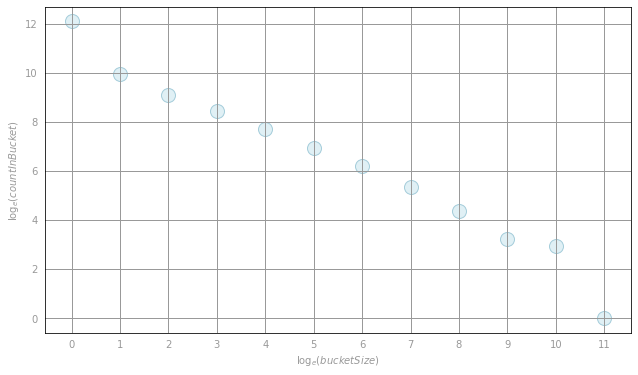

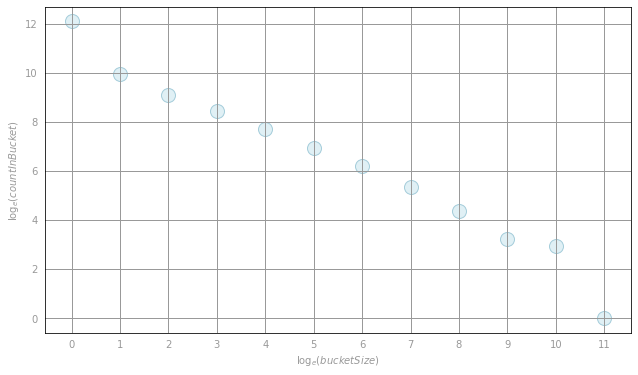

In [0]:
import matplotlib.pyplot as plt

x, y = zip(*feature_counts)
x, y = x, np.log(y)

def prepare_plot(xticks, yticks, figsize=(10.5, 6), hide_labels=False, grid_color='#999999',
                 grid_width=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hide_labels: axis.set_ticklabels([])
    plt.grid(color=grid_color, linewidth=grid_width, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

# generate layout and plot data
fig, ax = prepare_plot(np.arange(0, 12, 1), np.arange(0, 14, 2))
ax.set_xlabel(r'$\log_e(bucketSize)$'), ax.set_ylabel(r'$\log_e(countInBucket)$')
plt.scatter(x, y, s=14**2, c='#d6ebf2', edgecolors='#8cbfd0', alpha=0.75)
display(fig)

### (3f) Handling unseen features

We naturally would like to repeat the process from Part (3e), to compute OHE features for the validation and test datasets.  However, we must be careful, as some categorical values will likely appear in new data that did not exist in the training data. 

To deal with this situation, update the `one_hot_encoding()` function from Part (1d) to IGNORE previously unseen categories, and then compute OHE features for the validation data.  Remember that you can parse a raw DataFrame using `parse_raw_df`.


> Note: you'll have to generate a new UDF using `ohe_udf_generator` so that the updated `one_hot_encoding` function is used.  And make sure to cache `ohe_validation_df`.

In [0]:
# TODO: Uncomment the lines below and replace <FILL IN> with appropriate code
def one_hot_encoding(raw_feats, ohe_dict_broadcast, num_ohe_feats):
    """Produce a one-hot-encoding from a list of features and an OHE dictionary.

    Note:
        You should ensure that the indices used to create a SparseVector are sorted, and that the
        function handles missing features.

    Args:
        raw_feats (list of (int, str)): The features corresponding to a single observation.  Each
            feature consists of a tuple of featureID and the feature's value. (e.g. sample_one)
        ohe_dict_broadcast (Broadcast of dict): Broadcast variable containing a dict that maps
            (featureID, value) to unique integer.
        num_ohe_feats (int): The total number of unique OHE features (combinations of featureID and
            value).

    Returns:
        SparseVector: A SparseVector of length num_ohe_feats with indices equal to the unique
            identifiers for the (featureID, value) combinations that occur in the observation and
            with values equal to 1.0.
    """
    # YOUR CODE HERE
    index_list = []
    for f in raw_feats:
        if f in ohe_dict_broadcast.value.keys():
            index_list.append(ohe_dict_broadcast.value[f])
    index_list = sorted(index_list)
    value_list = [1] * len(index_list)
    return SparseVector(num_ohe_feats, index_list,value_list)
    raise NotImplementedError()

# ohe_dict_missing_udf = <FILL IN>
# ohe_validation_df = <FILL IN>

# YOUR CODE HERE
parsed_validation_df = parse_raw_df(raw_validation_df.select('text'))
ohe_dict_missing_udf = ohe_udf_generator(ohe_dict_broadcast)
ohe_validation_df = (parsed_validation_df.select('label', ohe_dict_missing_udf(parsed_validation_df.features)))
# ohe_validation_df = parsed_validation_df.select(ohe_dict_missing_udf("features"))
ohe_validation_df = ohe_validation_df.withColumnRenamed("<lambda>(features)","features")
ohe_validation_df.cache()
ohe_validation_df.count()
display(ohe_validation_df) # replace with ohe_validate_df.show() if running outside of Databricks

label,features
1,"Map(vectorType -> sparse, length -> 215556, indices -> List(6, 9, 22, 165, 168, 271, 35880, 35882, 35890, 35907, 35927, 35988, 36079, 36141, 36150, 36286, 37957, 43131, 71635, 71638, 71664, 71700, 72063, 73636, 78836, 81978, 107883, 107907, 107949, 107958, 108060, 108127, 115070, 115071, 179594, 179598, 180270, 181174, 186813), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0))"
0,"Map(vectorType -> sparse, length -> 215556, indices -> List(0, 1, 3, 9, 13, 14, 20, 60, 454, 602, 2058, 2766, 35881, 35882, 35907, 36310, 71630, 71632, 71637, 71642, 72077, 72173, 73731, 74437, 74438, 107881, 107898, 107931, 110643, 110644, 143872, 143918, 144206, 146595, 180003, 180077, 182342, 182404, 186319), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0))"
0,"Map(vectorType -> sparse, length -> 215556, indices -> List(1, 6, 9, 25, 49, 107, 2271, 35880, 35881, 35882, 35891, 35907, 35959, 36017, 36630, 37057, 71638, 71707, 71913, 105838, 105839, 105840, 107884, 107898, 107948, 144268, 144488, 145510, 177533, 179589, 179598, 179661, 179809, 179812, 179895, 181682), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0))"
0,"Map(vectorType -> sparse, length -> 215556, indices -> List(9, 12, 13, 14, 170, 177, 286, 739, 5567, 5568, 35880, 35881, 35882, 35927, 36132, 36278, 36382, 38608, 71632, 71635, 71638, 71670, 72549, 107881, 107972, 107993, 143886, 143898, 143900, 179576, 179581, 179682, 180205, 180822, 185150), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0))"
0,"Map(vectorType -> sparse, length -> 215556, indices -> List(1, 9, 12, 20, 25, 189, 201, 518, 815, 816, 35882, 35884, 35892, 36024, 36420, 36421, 36422, 71630, 71632, 71641, 72711, 107881, 107883, 107886, 107896, 108376, 108377, 143872, 143876, 145004, 179582, 179598, 179625, 179850, 180131, 180133, 180448, 182234, 194008), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0))"
1,"Map(vectorType -> sparse, length -> 215556, indices -> List(1, 6, 9, 12, 13, 14, 17, 30, 290, 291, 1712, 2888, 16147, 35882, 35889, 35907, 36005, 36136, 36219, 38554, 38828, 71632, 71636, 71680, 71867, 71956, 74539, 107884, 108169, 143911, 144143, 144149, 146376, 179625, 179632, 179671, 179676, 179690, 179891), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0))"
0,"Map(vectorType -> sparse, length -> 215556, indices -> List(1, 6, 12, 13, 25, 26, 38, 39, 218, 1535, 13016, 35880, 35882, 35884, 35890, 35893, 36380, 37452, 71630, 71632, 71641, 71651, 71677, 71963, 71965, 107882, 107884, 107886, 107898, 108172, 143876, 145381, 179591, 179632, 179676, 179690, 179894, 179931, 183691), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0))"
0,"Map(vectorType -> sparse, length -> 215556, indices -> List(1, 12, 13, 14, 49, 53, 64, 632, 21011, 21012, 21013, 35882, 35890, 35907, 36107, 36686, 71630, 71700, 74608, 92729, 107898, 107906, 108002, 108149, 128802, 143881, 143898, 143900, 144342, 144455, 148131, 179596, 179600, 179609, 179614, 179658, 179

In [0]:
# TEST Handling unseen features (3f)
from pyspark.sql.functions import size, sum as sqlsum

assert_true(ohe_validation_df.is_cached, 'you need to cache ohe_validation_df')
num_nz_val = (ohe_validation_df
                .select(sqlsum(size(get_indices('features'))))
                .first()[0])

nz_expected = 367573
assert_equal(num_nz_val, nz_expected, 'incorrect number of features: Got {0}, expected {1}'.format(num_nz_val, nz_expected))

## Part 4: CTR prediction and logloss evaluation

### (4a) Logistic regression

We are now ready to train our first CTR classifier.  A natural classifier for this setting is logistic regression, since it models the probability of a click-through event rather than returning a simple binary "yes" or "no". Also, when working with rare events like clicking-through, probabilistic predictions are usually more accurate.

First use [LogisticRegression](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.LogisticRegression.html) from the pyspark.ml package to train a model using `ohe_train_df` with a given hyperparameter configuration.  `LogisticRegression.fit` returns a [LogisticRegressionModel](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.LogisticRegressionModel.html).  

Next, we'll use the `LogisticRegressionModel.coefficients` and `LogisticRegressionModel.intercept` to print out some details of the model's parameters.  Note that these are the names of the object's attributes and should be called using a syntax like `model.coefficients` for a given `model`.

In [0]:
# TODO: Uncomment the lines below and replace <FILL IN> with appropriate code
# Given hyperparameters
standardization = False
elastic_net_param = 0.0
reg_param = .01
max_iter = 20

from pyspark.ml.classification import LogisticRegression
# Call LogisticRegression and set the above hyperparameters
# lr = <FILL IN>

# the LogisticRegressionModel
# lr_model_basic = <FILL IN>

# YOUR CODE HERE
# Call LogisticRegression and set the above hyperparameters
lr = LogisticRegression(regParam=reg_param, elasticNetParam=elastic_net_param, maxIter = max_iter, standardization = standardization)

# the LogisticRegressionModel
ohe_train_df = ohe_train_df.withColumn("label",ohe_train_df.label.cast('int'))
lr_model_basic = lr.fit(ohe_train_df)

print('intercept: {0}'.format(lr_model_basic.intercept))
print('length of coefficients: {0}'.format(len(lr_model_basic.coefficients)))
sorted_coefficients = sorted(lr_model_basic.coefficients)[:5]

intercept: -1.2666899694909888
length of coefficients: 215556


In [0]:
# TEST Logistic regression (4a)
assert_true(np.allclose(lr_model_basic.intercept,  -1.2666899694909888, atol=1e-2), 'incorrect value for model intercept')
assert_true(np.allclose(sorted_coefficients,
                           [-0.10112483295002224, -0.10062496362519648, -0.10062496362519648, -0.10062496362519648, -0.10062496362519648], atol=1e-2),
                           'incorrect value for model coefficients')

### (4b) Log loss
Throughout this lab, we will use log loss to evaluate the quality of models.  Log loss is defined as: \\[ \scriptsize \ell_{log}(p, y) = \begin{cases} -\log (p) & \text{if } y = 1 \\\ -\log(1-p) & \text{if } y = 0 \end{cases} \\] where \\( \scriptsize p\\) is a probability between 0 and 1 and \\( \scriptsize y\\) is a label of either 0 or 1. Log loss is a standard evaluation criterion when predicting rare-events such as click-through rate prediction.

Write a function `add_log_loss` for a DataFrame, and evaluate it on sample inputs.  This operation does not require a UDF.

In [0]:
# Some example data
example_log_loss_df = sqlContext.createDataFrame([(.5, 1), (.5, 0), (.99, 1), (.99, 0), (.01, 1),
                                                  (.01, 0), (1., 1), (.0, 1), (1., 0)], ['p', 'label'])
example_log_loss_df.show()

+----+-----+
|   p|label|
+----+-----+
| 0.5|    1|
| 0.5|    0|
|0.99|    1|
|0.99|    0|
|0.01|    1|
|0.01|    0|
| 1.0|    1|
| 0.0|    1|
| 1.0|    0|
+----+-----+



In [0]:
# TODO: Uncomment the lines below and replace <FILL IN> with appropriate code
from pyspark.sql.functions import when, log, col
from pyspark.sql.functions import format_number
epsilon = 1e-16

def add_log_loss(df):
    """Computes and adds a 'log_loss' column to a DataFrame using 'p' and 'label' columns.

    Note:
        log(0) is undefined, so when p is 0 we add a small value (epsilon) to it and when
        p is 1 we subtract a small value (epsilon) from it.

    Args:
        df (DataFrame with 'p' and 'label' columns): A DataFrame with a probability column
            'p' and a 'label' column that corresponds to y in the log loss formula.

    Returns:
        DataFrame: A new DataFrame with an additional column called 'log_loss'
    """
    # <FILL IN>
    # YOUR CODE HERE
    df_ll = df.withColumn("log_loss",
       when((col("p") == 0) & (col("label") == 0), -log(1-lit(epsilon)))
      .when((col("p") == 0) & (col("label") == 1), -log(col("p")+epsilon))
      .when((col("p") == 1) & (col("label") == 0), -log(lit(epsilon)))
      .when((col("p") == 1) & (col("label") == 1), -log(1-lit(epsilon)))
      .when((col("p") != 1) & (col("p") != 0) & (col("label") == 1), -log(col("p")))
      .when((col("p") != 1) & (col("p") != 0) & (col("label") == 0), -log(1-col("p"))))
    return df_ll
    raise NotImplementedError()
 
add_log_loss(example_log_loss_df).show()

+----+-----+--------------------+
|   p|label|            log_loss|
+----+-----+--------------------+
| 0.5|    1|  0.6931471805599453|
| 0.5|    0|  0.6931471805599453|
|0.99|    1| 0.01005033585350145|
|0.99|    0|    4.60517018598809|
|0.01|    1|   4.605170185988091|
|0.01|    0| 0.01005033585350145|
| 1.0|    1|1.110223024625156...|
| 0.0|    1|  36.841361487904734|
| 1.0|    0|  36.841361487904734|
+----+-----+--------------------+



In [0]:
# TEST Log loss (4b)
log_loss_values = add_log_loss(example_log_loss_df).select('log_loss').rdd.map(lambda r: r[0]).collect()
assert_true(np.allclose(log_loss_values[:-2],
                            [0.6931471805599451, 0.6931471805599451, 0.010050335853501338, 4.60517018598808,
                             4.605170185988081, 0.010050335853501338, -0.0], atol=1e-2), 'log loss is not correct')
assert_true(not(any(map(lambda x: x is None, log_loss_values[-2:]))),
                'log loss needs to bound p away from 0 and 1 by epsilon')

### (4c)  Baseline log loss

Next we will use the function we have in Part (4b) to compute the baseline log loss of the training data. A very simple yet natural baseline model is that we always make the same prediction regardless of datapoints, therefore the predicted value would be equal to the fraction of training points that correspond to click-through events (i.e., where the label is one). Compute this value (which is simply the mean of the training labels), and then use it to compute the training log loss for the baseline model.

> HINT: 
- remeber to add a `p` column to the `ohe_train_df` DataFrame so that it can be used in your function from Part (4b).

In [0]:
# TODO: Uncomment the lines below and replace <FILL IN> with appropriate code
# Note that our dataset has a very high click-through rate by design
# In practice click-through rate can be one to two orders of magnitude lower

from pyspark.sql.functions import lit, avg, sum
# ctr_fraction = (<FILL IN>)

# YOUR CODE HERE
ctr_fraction = ohe_train_df.select("label").agg(avg(col("label"))).take(1)[0][0]
print('Training class one fraction = {0:.3f}'.format(ctr_fraction))
ohe_train_df = ohe_train_df.withColumn("p",lit(ctr_fraction))

# log_loss_tr_base = (<FILL IN>)

# YOUR CODE HERE
log_loss_tr_base = add_log_loss(ohe_train_df).select(sum('log_loss')).take(1)[0][0]/ohe_train_df.count()
print('Baseline Train Logloss = {0:.3f}\n'.format(log_loss_tr_base))

Training class one fraction = 0.234
Baseline Train Logloss = 0.544



In [0]:
# TEST Baseline log loss (4c)
expected_frac = 0.2339125
expected_log_loss = 0.5439608117656105
assert_true(np.allclose(ctr_fraction, expected_frac, atol=1e-2), 'incorrect value for ctr_fraction. Got {0}, expected {1}'.format(ctr_fraction, expected_frac))
assert_true(np.allclose(log_loss_tr_base, expected_log_loss, atol=1e-2), 'incorrect value for log_loss_tr_base. Got {0}, expected {1}'.format(log_loss_tr_base, expected_log_loss))

### (4d) Predict probability

In order to compute the log loss for the model we trained in Part (4a), we need to generate predictions from this model. 
- Write a function that computes the raw linear prediction from this logistic regression model and then passes it through a [sigmoid function](http://en.wikipedia.org/wiki/Sigmoid_function) \\( \scriptsize \sigma(t) = (1+ e^{-t})^{-1} \\) to return the model's probabilistic prediction. 
- Then compute probabilistic predictions on the training data.
- In your implementation, we suggest using features.dot() rather than np.dot() to calculate the dot product between the features and the broadcast variable.

Note that when incorporating an intercept into our predictions, we simply add the intercept to the value of the prediction obtained from the weights and features.  

Alternatively, if the intercept was included as the first weight, we would need to add a corresponding feature to our data where the feature has the value one.  This is not the case here.

In [0]:
# TODO: Uncomment the lines below and replace <FILL IN> with appropriate code
from pyspark.sql.types import DoubleType
from math import exp #  exp(-t) = e^-t

def add_probability(df, model):
    """Adds a probability column ('p') to a DataFrame given a model"""
    coefficients_broadcast = sc.broadcast(model.coefficients)
    intercept = model.intercept

    def get_p(features):
        """Calculate the probability for an observation given a list of features.

        Note:
            We'll bound our raw prediction between 20 and -20 for numerical purposes.

        Args:
            features: the features

        Returns:
            float: A probability between 0 and 1.
        """
        # <FILL IN>
        prediction = features.dot(coefficients_broadcast.value)+intercept
        if prediction>20: prediction=20
        if prediction<-20: prediction=-20
        prob = 1.0/(1+exp(-prediction))
        return prob
        raise NotImplementedError()

    get_p_udf = udf(get_p, DoubleType())
    return df.withColumn('p', get_p_udf('features'))

add_probability_model_basic = lambda df: add_probability(df, lr_model_basic)
training_predictions = add_probability_model_basic(ohe_train_df).cache()

training_predictions.show(5,truncate = False)

+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+
|label|features                                                                                                                                                                                                                                                                                                                                                                                                             |p                  |
+-----+-----------------------------------------------------------------------------------------------------------------------------

In [0]:
# TEST Predicted probability (4d)
expected = 19540.547327176144
got = training_predictions.selectExpr('sum(p)').first()[0]
assert_true(np.allclose(got, expected, atol=1e-2),
                'incorrect value for training_predictions. Got {0}, expected {1}'.format(got, expected))

### (4e) Evaluate the model

We are now ready to evaluate the performance of the model we trained in Part (4a). To do this, first write a general function that takes a model and a DataFrame as its input, and outputs the log loss. 

Note that the log loss for multiple observations should be the mean of all the individual log losses. 

Then run this function on the OHE training data, and compare the result with the baseline log loss.

In [0]:
# TODO: Uncomment the lines below and replace <FILL IN> with appropriate code
def evaluate_results(df, model, baseline=None):
    """Calculates the log loss for the data given the model.

    Note:
        If baseline has a value the probability should be set to baseline before
        the log loss is calculated.  Otherwise, use add_probability to add the
        appropriate probabilities to the DataFrame.

    Args:
        df (DataFrame with 'label' and 'features' columns): A DataFrame containing
            labels and features.
        model (LogisticRegressionModel): A trained logistic regression model. This
            can be None if baseline is set.
        baseline (float): A baseline probability to use for the log loss calculation.

    Returns:
        float: Log loss for the data.
    """
    
    # with_probability_df = <FILL IN>
    # with_log_loss_df = <FILL IN>
    # log_loss = <FILL IN>
    # return log_loss

    # YOUR CODE HERE
    if baseline != None:
        with_probability_df = df.withColumn("p", lit(baseline))
    else:
        with_probability_df = add_probability(df, model)
    with_log_loss_df = add_log_loss(with_probability_df)
    
    log_loss = with_log_loss_df.select("log_loss").agg(avg(col("log_loss"))).take(1)[0][0]
    return log_loss
    raise NotImplementedError()


log_loss_train_model_basic = evaluate_results(ohe_train_df, lr_model_basic)
print('OHE Features Train Logloss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(log_loss_tr_base, log_loss_train_model_basic))

OHE Features Train Logloss:
	Baseline = 0.544
	LogReg = 0.490


In [0]:
# TEST Evaluate the model (4e)
expected_log_loss = 0.48971226940239815
assert_true(np.allclose(log_loss_train_model_basic, expected_log_loss, atol=1e-2),
                'incorrect value for log_loss_train_model_basic. Got {0}, expected {1}'.format(log_loss_train_model_basic, expected_log_loss))
expected_res = 0.6931471805600546
res = evaluate_results(ohe_train_df, None,  0.5)
assert_true(np.allclose(res, expected_res, atol=1e-2),
                'evaluate_results needs to handle baseline models. Got {0}, expected {1}'.format(res, expected_res))

### (4f) Log loss of validation dataset

Next, use the `evaluate_results` function and compute the log loss of validation dataset for both the baseline and logistic regression models. Notably, the baseline model for the validation dataset should still be based on the label fraction from the training dataset.

In [0]:
ohe_validation_df

Out[126]: DataFrame[features: vector]

In [0]:
# # TODO: Uncomment the lines below and replace <FILL IN> with appropriate code
# log_loss_val_base = <FILL IN>

# log_loss_val_l_r0 = <FILL IN>

# YOUR CODE HERE
log_loss_val_base = evaluate_results(ohe_validation_df, None,ctr_fraction)

log_loss_val_l_r0 = evaluate_results(ohe_validation_df, lr_model_basic)

print(('OHE Features Validation Logloss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(log_loss_val_base, log_loss_val_l_r0)))

OHE Features Validation Logloss:
	Baseline = 0.634
	LogReg = 0.576


In [0]:
# TEST Validation log loss (4f)
expected_val_base = 0.6344644324013423
assert_true(np.allclose(log_loss_val_base, expected_val_base, atol=1e-2),
                'incorrect value for log_loss_val_base. Got {0}, expected {1}'.format(log_loss_val_base, expected_val_base))
expected_val_model_basic = 0.5793520014798194
assert_true(np.allclose(log_loss_val_l_r0, expected_val_model_basic, atol=1e-2),
                'incorrect value for log_loss_val_l_r0. Got {0}, expected {1}'.format(log_loss_val_l_r0, expected_val_model_basic))

### Visualization 2: ROC curve

We will now visualize the performance of our model.  We generate a plot called the ROC curve.  The ROC curve shows us the trade-off between the false positive rate and true positive rate, as we liberalizing the threshold required for a positive prediction.  The performance of a random model is represented by the dashed line in the plot.

In [0]:
labels_and_scores = add_probability_model_basic(ohe_validation_df).select('label', 'p')
labels_and_weights = labels_and_scores.collect()
labels_and_weights.sort(key=lambda x: x[1], reverse=True)
labels_by_weight = np.array([k for (k, v) in labels_and_weights])

length = labels_by_weight.size
true_positives = labels_by_weight.cumsum()
num_positive = true_positives[-1]
false_positives = np.arange(1.0, length + 1, 1.) - true_positives

true_positive_rate = true_positives / num_positive
false_positive_rate = false_positives / (length - num_positive)

# Generate layout and plot data
fig, ax = prepare_plot(np.arange(0., 1.1, 0.1), np.arange(0., 1.1, 0.1))
ax.set_xlim(-.05, 1.05), ax.set_ylim(-.05, 1.05)
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
plt.plot(false_positive_rate, true_positive_rate, color='#8cbfd0', linestyle='-', linewidth=3.)
plt.plot((0., 1.), (0., 1.), linestyle='--', color='#d6ebf2', linewidth=2.)  # Baseline model
display(fig)

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
<command-3300230847040959> in <cell line: 7>()
      5 
      6 length = labels_by_weight.size
----> 7 true_positives = labels_by_weight.cumsum()
      8 num_positive = true_positives[-1]
      9 false_positives = np.arange(1.0, length + 1, 1.) - true_positives

TypeError: cannot perform accumulate with flexible type

## Part 5: Reduce features' dimension via feature hashing

### (5a) Hash function

As we just saw, using an one-hot-encoding featurization can yield a model with good statistical accuracy.  However, the number of distinct categories across all features is quite large -- recall that we observed 233K categories in the training data in Part (3c).Moreover, the full training dataset includes more than 33M distinct categories, and the training dataset itself is just a small subset of labeled data in real world.  

Hence, featurizing via an one-hot-encoding representation could lead to a very large feature vector. To reduce the dimensionality of the feature space, we will use feature hashing.

Below is a hash function that we will use for this part of the lab.  We will first use this hash function with the three sample data points from Part (1a) to gain some intuition.  

Implement the following code to hash those three sample points using two different values for `numBuckets` and observe the resulting hashed feature dictionaries.

In [0]:
from collections import defaultdict
import functools 
import hashlib

def hash_function(raw_feats, num_buckets, print_mapping=False):
    """Calculate a feature dictionary for an observation's features based on hashing.

    Note:
        Use print_mapping=True for debug purposes and to better understand how the hashing works.

    Args:
        raw_feats (list of (int, str)): A list of features for an observation.  Represented as
            (featureID, value) tuples.
        num_buckets (int): Number of buckets to use as features.
        print_mapping (bool, optional): If true, the mappings of featureString to index will be
            printed.

    Returns:
        dict of int to float:  The keys will be integers which represent the buckets that the
            features have been hashed to.  The value for a given key will contain the count of the
            (featureID, value) tuples that have hashed to that key.
    """
    mapping = { category + ':' + str(ind):
                int(int(hashlib.md5((category + ':' + str(ind)).encode('utf-8')).hexdigest(), 16) % num_buckets)
                for ind, category in raw_feats}
    if(print_mapping): print(mapping)

    def map_update(l, r):
        l[r] += 1.0
        return l

    sparse_features = functools.reduce(map_update, mapping.values(), defaultdict(float))
    return dict(sparse_features)

# Reminder of the sample values:
# sample_one = [(0, 'mouse'), (1, 'black')]
# sample_two = [(0, 'cat'), (1, 'tabby'), (2, 'mouse')]
# sample_three =  [(0, 'bear'), (1, 'black'), (2, 'salmon')]

In [0]:
# # TODO: Uncomment the lines below and replace <FILL IN> with appropriate code
# # Use four buckets
# samp_one_four_buckets = <FILL IN> 
# samp_two_four_buckets = <FILL IN> 
# samp_three_four_buckets = <FILL IN> 

# # Use one hundred buckets
# samp_one_hundred_buckets = <FILL IN> 
# samp_two_hundred_buckets = <FILL IN> 
# samp_three_hundred_buckets = <FILL IN> 

# YOUR CODE HERE
# Use four buckets
samp_one_four_buckets =  hash_function(sample_one, 4) 
samp_two_four_buckets = hash_function(sample_two, 4) 
samp_three_four_buckets = hash_function(sample_three, 4)  

# Use one hundred buckets
samp_one_hundred_buckets = hash_function(sample_one, 100) 
samp_two_hundred_buckets = hash_function(sample_two, 100) 
samp_three_hundred_buckets = hash_function(sample_three, 100) 

print('\n\t\t 4 Buckets \t\t\t 100 Buckets')
print('Sample One:\t {0}\t\t\t {1}'.format(samp_one_four_buckets, samp_one_hundred_buckets))
print('Sample Two:\t {0}\t\t {1}'.format(samp_two_four_buckets, samp_two_hundred_buckets))
print('Sample Three:\t {0}\t {1}'.format(samp_three_four_buckets, samp_three_hundred_buckets))


		 4 Buckets 			 100 Buckets
Sample One:	 {3: 2.0}			 {99: 1.0, 51: 1.0}
Sample Two:	 {1: 2.0, 0: 1.0}		 {21: 1.0, 72: 1.0, 9: 1.0}
Sample Three:	 {2: 1.0, 3: 1.0, 0: 1.0}	 {82: 1.0, 51: 1.0, 80: 1.0}


In [0]:
# TEST Hash function (5a)
assert_equal(samp_one_four_buckets, {3: 2.0}, 'incorrect value for samp_one_four_buckets')
assert_equal(samp_three_hundred_buckets, {80: 1.0, 82: 1.0, 51: 1.0},
                  'incorrect value for samp_three_hundred_buckets')

### (5b) Create hashed features

Next, we will use this hash function to create hashed features for our CTR datasets. 

- Use the given UDF to create a function that takes in a DataFrame and returns both labels and hashed features. 
- Then use it to create new training, validation and test datasets with hashed features.

In [0]:
# TODO: Uncomment the lines below and replace <FILL IN> with appropriate code
from pyspark.ml.linalg import Vectors
num_hash_buckets = 2 ** 15

# UDF that returns a vector of hashed features given an Array of tuples
tuples_to_hash_features_udf = udf(lambda x: Vectors.sparse(num_hash_buckets, hash_function(x, num_hash_buckets)), VectorUDT())

def add_hashed_features(df):
    """Return a DataFrame with labels and hashed features.

    Note:
        Make sure you cache the DataFrame that you are returning.

    Args:
        df (DataFrame with 'label' and 'features' column): A DataFrame containing labels and the features to be hashed.

    Returns:
        DataFrame: A DataFrame with a 'label' column and a 'features' column that contains a
            SparseVector of hashed features.
    """
    # YOUR CODE HERE
    df_tuples = df.select(df.label, tuples_to_hash_features_udf('features'))
    return df_tuples
    
    raise NotImplementedError()

# hash_train_df = <FILL IN>
# hash_validation_df = <FILL IN>
# hash_test_df = <FILL IN>

# YOUR CODE HERE
hash_train_df = add_hashed_features(parsed_train_df)
hash_train_df = hash_train_df.withColumnRenamed("<lambda>(features)","features")
hash_train_df = hash_train_df.withColumn("label",hash_train_df.label.cast('int'))

hash_validation_df = add_hashed_features(parsed_validation_df)
hash_validation_df = hash_validation_df.withColumnRenamed("<lambda>(features)","features")
hash_validation_df = hash_validation_df.withColumn("label",hash_validation_df.label.cast('int'))

parsed_test_df = parse_raw_df(raw_test_df.select('text'))
hash_test_df = add_hashed_features(parsed_test_df)
hash_test_df = hash_test_df.withColumnRenamed("<lambda>(features)","features")
hash_test_df = hash_test_df.withColumn("label",hash_test_df.label.cast('int'))

hash_train_df.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|(32768,[24,626,14...|
|    0|(32768,[863,1597,...|
|    0|(32768,[119,254,8...|
|    0|(32768,[1597,2087...|
|    0|(32768,[372,1597,...|
|    0|(32768,[856,962,1...|
|    0|(32768,[86,890,12...|
|    0|(32768,[745,2480,...|
|    0|(32768,[1232,1597...|
|    0|(32768,[577,856,1...|
|    0|(32768,[3406,3935...|
|    0|(32768,[856,1146,...|
|    0|(32768,[473,1089,...|
|    0|(32768,[603,856,9...|
|    0|(32768,[8,1233,27...|
|    0|(32768,[771,856,1...|
|    0|(32768,[494,1045,...|
|    0|(32768,[24,1408,1...|
|    0|(32768,[1014,1408...|
|    0|(32768,[856,1233,...|
+-----+--------------------+
only showing top 20 rows



In [0]:
# TEST Creating hashed features (5b)
hash_train_df_feature_sum = sum(hash_train_df
                                  .rdd
                                  .map(lambda r: sum(r[1].indices))
                                  .take(10))
hash_validation_df_feature_sum = sum(hash_validation_df
                                       .rdd
                                       .map(lambda r: sum(r[1].indices))
                                       .take(10))
hash_test_df_feature_sum = sum(hash_test_df
                                 .rdd
                                 .map(lambda r: sum(r[1].indices))
                                 .take(10))

expected_train_sum = 6333443
assert_equal(hash_train_df_feature_sum, expected_train_sum,
                  'incorrect number of features in hash_train_df. Got {0}, expected {1}'.format(hash_train_df_feature_sum, expected_train_sum))

expected_validation_sum = 6340030
assert_equal(hash_validation_df_feature_sum, expected_validation_sum,
                  'incorrect number of features in hash_validation_df. Got {0}, expected {1}'.format(hash_validation_df_feature_sum, expected_validation_sum))

---------------------------------------------------------------------------
Py4JJavaError                             Traceback (most recent call last)
<command-3300230847040967> in <cell line: 2>()
      1 # TEST Creating hashed features (5b)
----> 2 hash_train_df_feature_sum = sum(hash_train_df
      3                                   .rdd
      4                                   .map(lambda r: sum(r[1].indices))
      5                                   .take(10))

/databricks/spark/python/pyspark/rdd.py in take(self, num)
   1921 
   1922             p = range(partsScanned, min(partsScanned + numPartsToTry, totalParts))
-> 1923             res = self.context.runJob(self, takeUpToNumLeft, p)
   1924 
   1925             items += res

/databricks/spark/python/pyspark/context.py in runJob(self, rdd, partitionFunc, partitions, allowLocal)
   1604             finally:
   1605                 os.remove(filename)
-> 1606         sock_info = self._jvm.PythonRDD.runJob(self._jsc.sc(), map

### (5c) Sparsity

Since we only have 33K hashed features versus 233K OHE features, we could expect our OHE features to be sparser.
- Verify this hypothesis by computing the average sparsity of the OHE and the hashed training datasets.

HINT:  if you have a `SparseVector` named `sparse`, calling `len(sparse)` returns the total number of features, not the number features with entries.  
HINT: check the documentation of `SparseVector` objects, pay attention to attributes `indices` and `values`, see what is returned by calling `sparse.indices` and `sparse.values`, respectively.

In [0]:
# TODO: Uncomment the lines below and replace <FILL IN> with appropriate code
def vector_feature_sparsity(sparse_vector):
    """Calculates the sparsity of a SparseVector.

    Args:
        sparse_vector (SparseVector): The vector containing the features.

    Returns:
        float: The ratio of features found in the vector to the total number of features.
    """
    # YOUR CODE HERE
    return len(sparse_vector.indices)*1/len(sparse_vector) 
    raise NotImplementedError()

a_sparse_vector = Vectors.sparse(5, {0: 1.0, 3: 1.0})
a_sparse_vector_sparsity = vector_feature_sparsity(a_sparse_vector)
print('This vector should have sparsity 2/5 or .4.')
print('Sparsity = {0:.2f}.'.format(a_sparse_vector_sparsity))

This vector should have sparsity 2/5 or .4.
Sparsity = 0.40.


In [0]:
# TEST Sparsity (5c)
assert_equal(a_sparse_vector_sparsity, .4,
                'incorrect value for a_sparse_vector_sparsity')

### (5d) Sparsity continued

Now we have a function to calculate vector sparsity, we'll wrap it up in a UDF and apply it to the entire DataFrame to obtain the average sparsity of features in that DataFrame.  

Implement the follwoing function to calculate the average sparsity of 
- the one-hot-encoded training DataFrame
- the hashed training DataFrame.

In [0]:
# TODO: Uncomment the lines below and replace <FILL IN> with appropriate code
feature_sparsity_udf = udf(vector_feature_sparsity, DoubleType())

def get_sparsity(df):
    """Calculates the average sparsity for the features in a DataFrame.

    Args:
        df (DataFrame with 'features' column): A DataFrame with sparse features.

    Returns:
        float: The average feature sparsity.
    """
    # YOUR CODE HERE
    return df.select(feature_sparsity_udf('features').alias('sparse')).agg(avg(col("sparse"))).take(1)[0][0]

    raise NotImplementedError()

# average_sparsity_ohe = <FILL IN>
# average_sparsity_hash = <FILL IN>

# YOUR CODE HERE
average_sparsity_ohe = get_sparsity(ohe_train_df)
average_sparsity_hash = get_sparsity(hash_train_df)

print('Average OHE Sparsity: {0:.7e}'.format(average_sparsity_ohe))
print('Average Hash Sparsity: {0:.7e}'.format(average_sparsity_hash))

Average OHE Sparsity: 1.8092746e-04
Average Hash Sparsity: 1.1895943e-03


In [0]:
# TEST Sparsity (5d)
expected_ohe = 1.8092746e-04
assert_true(np.allclose(average_sparsity_ohe, expected_ohe, atol=1e-2),
                'incorrect value for average_sparsity_ohe. Got {0}, expected {1}'.format(average_sparsity_ohe, expected_ohe))
expected_hash = 1.1895943e-03
assert_true(np.allclose(average_sparsity_hash, expected_hash, atol=1e-2),
                'incorrect value for average_sparsity_hash. Got {0}, expected {1}'.format(average_sparsity_hash, expected_hash))

### (5e) Logistic model with hashed features

Now let's train a logistic regression model using the hashed training features. Use the given hyperparameters, train and fit the model, then evaluate the log loss on the training set.

In [0]:
# TODO: Uncomment the lines below and replace <FILL IN> with appropriate code
# Given hyperparameters
standardization = False
elastic_net_param = 0.7
reg_param = .001
max_iter = 20

# lr_hash = <FILL IN>

# lr_model_hashed = <FILL IN>

# YOUR CODE HERE
lr_hash =  LogisticRegression(maxIter = max_iter, regParam = reg_param, elasticNetParam = elastic_net_param, standardization = standardization)

lr_model_hashed =  lr_hash.fit(hash_train_df)

print('intercept: {0}'.format(lr_model_hashed.intercept))
print(len(lr_model_hashed.coefficients))

log_loss_train_model_hashed = evaluate_results(hash_train_df, lr_model_hashed)
print(('OHE Features Train Logloss:\n\tBaseline = {0:.3f}\n\thashed = {1:.3f}'
       .format(log_loss_tr_base, log_loss_train_model_hashed)))

intercept: -1.3270568265558584
32768
OHE Features Train Logloss:
	Baseline = 0.544
	hashed = 0.481


In [0]:
# TEST Logistic model with hashed features (5e)
expected =  0.481478172974873
assert_true(np.allclose(log_loss_train_model_hashed, expected, atol=1e-2),
                'incorrect value for log_loss_train_model_hashed. Got {0}, expected {1}'.format(log_loss_train_model_hashed, expected))

### (5f) Evaluate the performance on the test set

Finally, we will evaluate the model from Part (5e) on the test set.  Compare the resulting log loss with the baseline log loss on the test set, which can be computed in the same way where the validation log loss was computed in Part (4f).

In [0]:
# # TODO: Uncomment the lines below and replace <FILL IN> with appropriate code
# # Log loss for the best model from (5e)
# log_loss_test = <FILL IN>

# YOUR CODE HERE
log_loss_test = evaluate_results(hash_test_df, lr_model_hashed)

# ## Log loss for the baseline model
# Use train lables to calculate this as test labels will not be available
# print('Class one fraction for test data: {0}'.format(ctr_fraction))
# log_loss_test_baseline = <FILL IN>

# YOUR CODE HERE
print('Class one fraction for test data: {0}'.format(ctr_fraction))
log_loss_test_baseline =  evaluate_results(hash_test_df, None, ctr_fraction)

print(('Hashed Features Test Log Loss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(log_loss_test_baseline, log_loss_test)))

Class one fraction for test data: 0.2339125
Hashed Features Test Log Loss:
	Baseline = 0.644
	LogReg = 0.573


In [0]:
# TEST Evaluate on the test set (5f)
expected_test_baseline = 0.6443111314185229
assert_true(np.allclose(log_loss_test_baseline, expected_test_baseline, atol=1e-2),
                'incorrect value for log_loss_test_baseline. Got {0}, expected {1}'.format(log_loss_test_baseline, expected_test_baseline))
expected_test = 0.5748571343610652
assert_true(np.allclose(log_loss_test, expected_test, atol=1e-2),
                'incorrect value for log_loss_test. Got {0}, expected {1}'.format(log_loss_test, expected_test))